# Face recognition using Convolutional Neural Network #

### Retrieving the data ###

In [4]:
import os

#main directory with data - containing subfolders whose names means the person's name
data_dir = 'data'
persons = os.listdir(data_dir) #get all subdirectories - one folder means one person

#create list of numbers from 0 to label each person
labels = []
for i in range(0, len(persons)):
    labels.append(i)

#create a person-label dict to retrieve the name from the number at the end
label_dict = dict(zip(persons, labels))

class_number = len(persons)


### Data preprocessing - converting into gray scale and resizing

In [11]:
import cv2 #OpenCV 

haarcascade_absolute_path = os.path.abspath("haarcascade/haarcascade_frontalface_default.xml")
#load Haar Cascade Classifiers to detect a face in the picture
face_cascade = cv2.CascadeClassifier(haarcascade_absolute_path) 


In [12]:
import numpy as np
import math
 
def gamma_correction(gray_img):
    # compute gamma = log(mid*255)/log(mean)
    mid = 0.5
    mean = np.mean(gray_img)
    gamma = math.log(mid*255)/math.log(mean)

    # do gamma correction
    img_gamma1 = np.power(gray_img, gamma).clip(0,255).astype(np.uint8)

    return img_gamma1

In [16]:
import imutils

image_size = 96 #the size of photo after resizing
X_1 = [] #the list for resized images - both train and test data for the neural network
y_1 = [] #the list for labels for both train and test data



def preprocess_data():
    for person in persons: #for each person (each subfolder)
        subfolder_path = os.path.join(data_dir, person)
        files = os.listdir(subfolder_path) #names of the files in one subfolder

        for file in files:
            image_path = os.path.join(subfolder_path, file) #get an image path

            if image_path.endswith(".jpg") or image_path.endswith(".png"):
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #change a color photo to gray
                image = gamma_correction(image) # gamma correction
                
                for i in range(-10,15,2):
                    image = imutils.rotate(image, angle=i)
                    detected_face = face_cascade.detectMultiScale(image, 1.3, 5) #detect a face
                    if len(detected_face) == 0:
                        os.remove(image_path) #delete a photo if no face was detected

                    for x, y, w, h in detected_face:
                        resized_image = cv2.resize((image[y : y+h, x : x+w]), (image_size, image_size))

                    resized_image = resized_image.astype("float32")
                    resized_image /= 255

                    X_1.append(resized_image) #add resized gray image to x_train list
                    y_1.append(label_dict[person]) #add the person's label (number) to y_train list
            


In [17]:
preprocess_data()

In [18]:
from sklearn.model_selection import train_test_split


#split the data into training, testing and validation sets
x_train, x_test, y_train, y_test = train_test_split(
    X_1, y_1, test_size=0.2, random_state=42, shuffle=True)

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, shuffle=True)

In [21]:
dataset_size = len(x_train)

In [22]:
x_train[0] #print the first image to check if it was correctly loaded

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.12156863, 0.12156863, 0.16078432, ..., 0.10196079, 0.10196079,
        0.09803922],
       [0.11372549, 0.13333334, 0.17254902, ..., 0.10980392, 0.09019608,
        0.09411765],
       [0.11372549, 0.14901961, 0.15294118, ..., 0.11764706, 0.10980392,
        0.11372549]], dtype=float32)

In [23]:
y_train[0:10] #print first 10 labels to check if the list was correctly populated

[1, 2, 0, 0, 3, 0, 1, 3, 2, 0]

In [ ]:
import matplotlib.pyplot as plt

#plot an image
def showOpencvImage(image, isGray=False):
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.show()
    
showOpencvImage(x_train[0])

In [25]:
#expand the shape of an array - insert a new axis - required for Conv2D layer in CNN
x_train = np.expand_dims(x_train, 3)
x_test = np.expand_dims(x_test, 3)
x_val = np.expand_dims(x_val, 3)

In [26]:
#check the shape after change
x_train.shape

(511, 96, 96, 1)

In [27]:
from keras.utils import to_categorical

print('y_train before encoding: \n', y_train)

#converts a vector to binary class matrix - one hot encoding
encoded_y_train = to_categorical(y_train)
encoded_y_test = to_categorical(y_test)
encoded_y_val = to_categorical(y_val)

print('\ny_train after encoding: \n', encoded_y_train)

y_train before encoding: 
 [1, 2, 0, 0, 3, 0, 1, 3, 2, 0, 3, 2, 2, 1, 0, 1, 3, 0, 2, 3, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 3, 2, 0, 0, 3, 1, 1, 2, 2, 2, 0, 1, 1, 3, 0, 2, 1, 0, 3, 1, 1, 3, 2, 0, 3, 2, 0, 1, 0, 1, 3, 0, 1, 3, 3, 3, 3, 3, 2, 3, 3, 1, 2, 3, 1, 3, 1, 0, 3, 2, 0, 1, 3, 2, 1, 0, 0, 2, 3, 1, 2, 1, 3, 3, 0, 3, 3, 0, 0, 0, 2, 1, 2, 1, 3, 2, 0, 3, 0, 3, 2, 3, 0, 2, 3, 3, 0, 0, 0, 1, 0, 1, 0, 1, 3, 3, 2, 1, 3, 0, 2, 0, 2, 3, 1, 3, 2, 1, 1, 0, 2, 2, 1, 1, 2, 1, 2, 0, 3, 2, 2, 2, 2, 0, 0, 0, 1, 2, 1, 0, 0, 2, 1, 2, 3, 0, 0, 1, 2, 3, 0, 3, 1, 1, 3, 2, 2, 3, 0, 2, 3, 2, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 2, 3, 0, 1, 1, 0, 1, 1, 0, 0, 3, 1, 1, 1, 2, 2, 3, 0, 3, 0, 0, 2, 1, 1, 1, 0, 3, 0, 3, 0, 2, 0, 3, 0, 2, 3, 3, 2, 1, 1, 0, 3, 3, 1, 1, 1, 3, 3, 2, 1, 2, 2, 2, 3, 2, 2, 0, 1, 2, 2, 3, 1, 0, 3, 2, 2, 3, 3, 1, 2, 3, 0, 0, 2, 1, 0, 1, 1, 0, 0, 1, 1, 3, 3, 3, 2, 0, 0, 2, 2, 2, 3, 2, 0, 0, 0, 2, 2, 2, 2, 0, 3, 2, 2, 1, 3, 3, 2, 1, 2, 3, 3, 1, 3, 0, 1, 3, 2, 0, 1, 1, 3, 2, 1, 0, 2, 1, 3, 3, 3, 0, 

In [28]:
encoded_y_train.shape

(511, 4)

Data preprocessing finished

### Convolutional Neural Network Model ###

In [1]:
#source for CNN model: https://thinkingneuron.com/face-recognition-using-deep-learning-cnn-in-python/

from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D

classifier = Sequential()
 
#convolution layer with (image_size, image_size, 1) input_shape 
#because we have only 1 matrix of size (image_size x image_size) - the image is gray
classifier.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), input_shape=(image_size, image_size, 1), activation='relu'))
 
#max pooling
classifier.add(MaxPooling2D(pool_size=(2, 2)))
 
#additional convolution
classifier.add(Conv2D(32, kernel_size=(5, 5), activation='relu'))
 
classifier.add(MaxPooling2D(pool_size=(2, 2)))
 
#flattening layer
classifier.add(Flatten())

#fully connection
classifier.add(Dense(16, activation='relu'))

#final layer with class_number size - the number corresponds to the number of different labels that we have
classifier.add(Dense(class_number, activation='softmax'))
 
#compilation
classifier.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ["accuracy"])
 


NameError: name 'image_size' is not defined

In [30]:
#model summary
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 92, 92, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14112)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                225808    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 6

In [31]:
history = classifier.fit(
    x_train, 
    encoded_y_train, 
    epochs=10, 
    batch_size=32, 
    shuffle=True, 
    validation_data=(x_val, encoded_y_val)
)


Epoch 1/10
16/16 [==============================] - 15s 816ms/step - loss: 0.9385 - accuracy: 0.6366 - val_loss: 0.0106 - val_accuracy: 1.0000
Epoch 2/10
16/16 [==============================] - 10s 603ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 1.0580e-05 - val_accuracy: 1.0000
Epoch 3/10
16/16 [==============================] - 10s 600ms/step - loss: 5.9960e-06 - accuracy: 1.0000 - val_loss: 8.1118e-07 - val_accuracy: 1.0000
Epoch 4/10
16/16 [==============================] - 10s 628ms/step - loss: 2.2025e-06 - accuracy: 1.0000 - val_loss: 5.4389e-07 - val_accuracy: 1.0000
Epoch 5/10
16/16 [==============================] - 11s 683ms/step - loss: 2.0294e-06 - accuracy: 1.0000 - val_loss: 4.7218e-07 - val_accuracy: 1.0000
Epoch 6/10
16/16 [==============================] - 10s 622ms/step - loss: 1.4380e-06 - accuracy: 1.0000 - val_loss: 4.3958e-07 - val_accuracy: 1.0000
Epoch 7/10
16/16 [==============================] - 11s 667ms/step - loss: 7.3902e-07 - accuracy: 1.0000 -

The achieved acucracy for training data equals 100% and the loss is very small

In [32]:
results = classifier.evaluate(x_test, encoded_y_test)
print()
print(classifier.metrics_names)
print("Results:", results)

5/5 [==============================] - 1s 188ms/step - loss: 3.9799e-05 - accuracy: 1.0000

['loss', 'accuracy']
Results: [3.979857137892395e-05, 1.0]


For validation data the results are also very good - the accuracy equals 100% and the loss is very small also

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
# plot 
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


#display the loss and accuracy curves
def show_plots(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.clf()   # clear figure

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    
#predict
def predict_and_show_reports(x_test, test_labels):
    predictions = classifier.predict(x_test)
    cm = confusion_matrix(test_labels, np.argmax(predictions, axis=1))
    print("Confusion matrix:\n", cm)
    print(classification_report(test_labels, np.argmax(predictions, axis=1)))
    

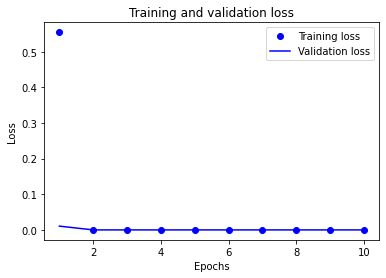

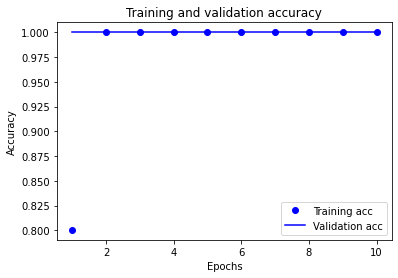

Confusion matrix:
 [[37  0  0  0]
 [ 0 43  0  0]
 [ 0  0 35  0]
 [ 0  0  0 45]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        43
           2       1.00      1.00      1.00        35
           3       1.00      1.00      1.00        45

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160



In [35]:
show_plots(history)
predict_and_show_reports(x_test, y_test)

In the diagrams above there we the overfitting can occur. Let's check the results once again with different parameters

In [49]:
classifier = Sequential() 
classifier.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), input_shape=(image_size, image_size, 1), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Conv2D(8, kernel_size=(5, 5), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Flatten())
classifier.add(Dense(4, activation='relu'))
classifier.add(Dense(class_number, activation='softmax'))
 
classifier.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ["accuracy"])


In [50]:
#model summary
classifier.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 92, 92, 16)        416       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 46, 46, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 42, 42, 8)         3208      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 21, 21, 8)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3528)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 14116     
_________________________________________________________________
dense_9 (Dense)              (None, 4)                

In [51]:
history = classifier.fit(
    x_train, 
    encoded_y_train, 
    epochs=7, 
    batch_size=32, 
    shuffle=True, 
    validation_data=(x_val, encoded_y_val)
)

Epoch 1/7
16/16 [==============================] - 6s 296ms/step - loss: 1.3034 - accuracy: 0.4487 - val_loss: 0.7395 - val_accuracy: 0.5703
Epoch 2/7
16/16 [==============================] - 4s 282ms/step - loss: 0.7160 - accuracy: 0.6528 - val_loss: 0.3859 - val_accuracy: 0.8047
Epoch 3/7
16/16 [==============================] - 4s 270ms/step - loss: 0.3996 - accuracy: 0.7849 - val_loss: 0.2054 - val_accuracy: 0.9688
Epoch 4/7
16/16 [==============================] - 4s 268ms/step - loss: 0.1978 - accuracy: 0.9694 - val_loss: 0.0588 - val_accuracy: 0.9922
Epoch 5/7
16/16 [==============================] - 4s 270ms/step - loss: 0.0466 - accuracy: 0.9937 - val_loss: 0.0082 - val_accuracy: 1.0000
Epoch 6/7
16/16 [==============================] - 4s 279ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 7/7
16/16 [==============================] - 4s 277ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000


In [52]:
results = classifier.evaluate(x_test, encoded_y_test)
print()
print(classifier.metrics_names)
print("Results:", results)

5/5 [==============================] - 1s 76ms/step - loss: 0.0024 - accuracy: 1.0000

['loss', 'accuracy']
Results: [0.0024451385252177715, 1.0]


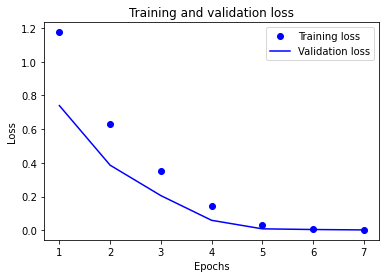

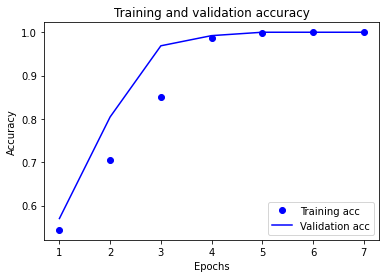

Confusion matrix:
 [[37  0  0  0]
 [ 0 43  0  0]
 [ 0  0 35  0]
 [ 0  0  0 45]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        43
           2       1.00      1.00      1.00        35
           3       1.00      1.00      1.00        45

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160



In [53]:
show_plots(history)
predict_and_show_reports(x_test, y_test)

The neural network is now more optimized and ready to make predictions

Check the result of prediction for one test picture:

In [54]:
pred_probabilities = classifier.predict(x_test)

In [58]:
import random

random_num = random.randint(0, len(x_test))
random_predicted = pred_probabilities[random_num]


In [ ]:
pred_labels = np.argmax(random_predicted, -1)
print(pred_labels)
print(persons[y_test[random_num]])
x_test_3_dim = np.squeeze(x_test)
showOpencvImage(x_test_3_dim[random_num])

In [60]:
#save the trained CNN model
classifier.save('face_recognition_model.h5')

A new photo was classified properly